In [1]:
# Clear workspace
rm(list = ls())
# Load libraries
library(IRdisplay)
library(igraph)
igraph_options(vertex.frame.color = "white", vertex.frame.size = 1)
library(tidyverse)
theme_set(new = theme_light())
mygreen <- hcl(h = c(135), c = 70, l = 80)
options(repr.plot.width = 4*1.5, repr.plot.height = 3*1.5)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()


# >Who are we (CoMuNe Lab)?

In [2]:
IRdisplay::display_html('<blockquote class="twitter-tweet" data-lang="it">
<p lang="en" dir="ltr">
Day 0: the Lab is complete and starting in the best possible way with 
i) talented researchers (physicists, applied mathematicians, engineers, social scientists &amp; neuroscientists), 
ii) encouraging gender balance &amp; 
iii) an avg age of ~30yr. 
<br>Ready to <a href="https://twitter.com/hashtag/NetworkScience?src=hash&amp;ref_src=twsrc%5Etfw">#NetworkScience</a> 
rock &#39;n roll ! <a href="https://t.co/0FWJUeb7Ga">pic.twitter.com/0FWJUeb7Ga</a>
</p>
&mdash; CoMuNe Lab (@ComuneLab) 
<a href="https://twitter.com/ComuneLab/status/1059523613932613632?ref_src=twsrc%5Etfw">5 novembre 2018</a>
</blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>')


Day 0: the Lab is complete and starting in the best possible way with 
i) talented researchers (physicists, applied mathematicians, engineers, social scientists & neuroscientists), 
ii) encouraging gender balance & 
iii) an avg age of ~30yr. 
 Ready to #NetworkScience 
rock 'n roll ! pic.twitter.com/0FWJUeb7Ga 
 
— CoMuNe Lab (@ComuneLab) 
 5 novembre 2018

# Networks: A very brief Introduction

A seminar series on Networks for the Masters in Math and Data Science.


Practical Issues:

* R needed
* I am using Jupyter Notebooks (read [this, on _Nature_](https://www.nature.com/articles/d41586-018-07196-1) to see how **cool** Jupyter is!!):
    
    * http://jupyter.org/install
    * https://irkernel.github.io/installation/
    * just as Rmarkdown (code not in chunks but in code-cells and markdown in markdown-cells)
    * [Binder](https://mybinder.org/)

## Contents

0. Why do we study Networks?

  * Complex Systems
  * Network Modeling


1. Fundamentals of Graph Theory
  * Definitions
  * The Laplacian of a Graph
  * Random Walks and Graphs
  
<div style="color:gray; padding-right:30pt; padding-top:30pt;">  
    <ol start="2">
        <li> Network Centrality</li>
        <li> Community Detection</li>
        <li> _Current Research at CoMuNe Lab - FBK_ </li>
    </ol>
</div>

## References

Ognyanova, K. (2016) *Networks analysis with R and igraph: NetSci X Tutorial.* Retrieved from [www.kateto.net/networks-r-igraph](http://kateto.net/networks-r-igraph).

Newman, M. (2018). *Networks*. Oxford university press.

Masuda, N., Porter, M. A., & Lambiotte, R. (2017). Random walks and diffusion on networks. [Physics reports.](https://doi.org/10.1016/j.physrep.2017.07.007)

## 0. Why do we study Networks?

### Complex Systems

[Top 20 Papers That Will Introduce You to Complexity Theory Research
](http://complexitylabs.io/top-20-papers-that-will-introduce-you-to-complexity-theory-research/)

**Focus shift**: from the analysis of small graphs (with tens of vertices) and individual nodes/edges features to the study of very large systems (millions of entities) and their large-scale statistical properties.

##### Some Keywords:

* interacting parts
* emergence
* collective behaviour
* self-organisation
* evolution
* patterns
* non-linearity
* ...

##### Some examples

* Ecosystems
* Human body or brain...
* An [ant colony](https://www.quantamagazine.org/ants-build-complex-structures-with-a-few-simple-rules-20140409/)
* ...
* Millennium Bridge, London, 2000

<span style="color:#0167b5;background:#f0dbcc;font-size:18pt;line-height:1.5em;">Networks are a natural framework for representing and studying systems of ineracting unitns.</span>

In [3]:
IRdisplay::display_html('<iframe width="560" height="315" 
                          src="https://www.youtube.com/embed/eAXVa__XWZ8" 
                          frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; 
                          picture-in-picture" allowfullscreen></iframe>')

### Network Modeling

Networks as mathematical models of complex systems, [Borgatti, Halgin 2011](http://steveborgatti.com/papers/orsc.1110.0641.pdf).

> A graph $G = (V, E)$ is a pair of sets, where the elements of $V$ are called _vertices_ (nodes), $E \subseteq V \times V$.
>
> For $u, v \in V$, $(u, v) \in E$, or $\{u, v\} \in E$ if $G$ is undirected, are called _edges_. 

Elements ~ **vertices**, interactions and relationships ~ **edges**. 

The pattern of connections in a network yields a particular network structure so we can study its characteristics (e.g. edge denity, rich-clubs, **community structure** etc.) and what position vertices occupy (node **centrality**).


#### Importance of Network Modeling

* Framework with applications in various fiedls
* Model: simplify and find key feature of the problem

## 1. Fundamentals of Graph Theory

Throughout this course we are going to mix theory and practice, so to have a rough idea of network analysis in R.

R packages required:

* `igraph`, see [`igraph`'s documentation](http://igraph.org/r/doc/);
* `igraphdata`

### 1.1 Definitions

###### Def. (Graph)
A graph $G = (V, E)$ is a pair of sets, where the elements of $V$ are called vertices (nodes), $E \subseteq V \times V$, whit $(u, v) \in E$ (if $G$ is undirected $\{u, v\}$) is an _edge_ for $u, v \in V$. 

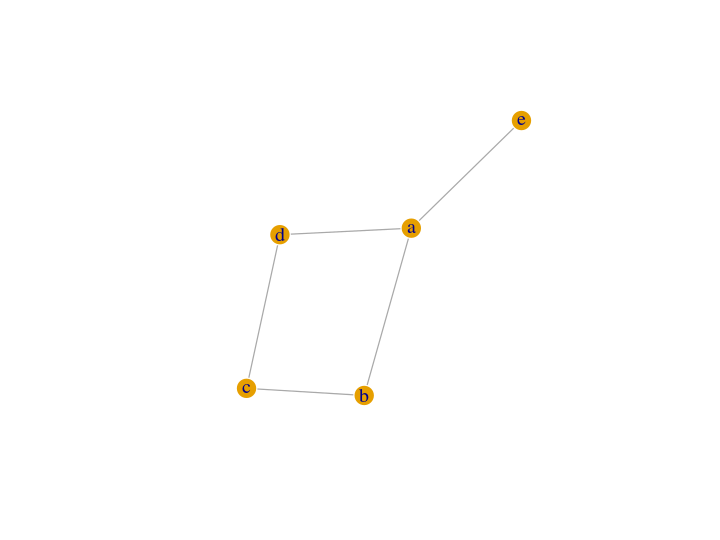

In [4]:
g <- make_graph(edges = c("a", "b", "b", "c", "a", "d", "c", "d", "a", "e"), directed = FALSE)
plot(g)

Networks do not have to be _connected_. A disconnected network is one in which some nodes cannot reach certain others by any path; the network is divided into _components_. Nodes without any adjacent are said to be _isolated_.

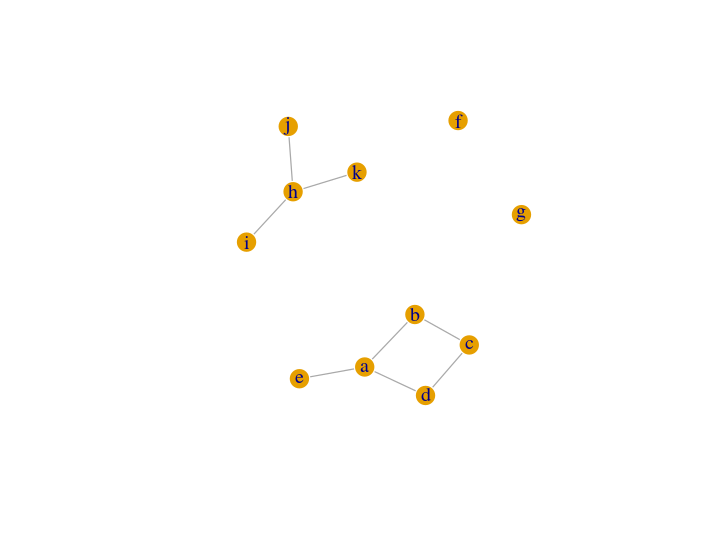

In [5]:
g <- make_graph(edges = c("a", "b", "b", "c", "a", "d", "c", "d", "a", "e", "h", "i", "h", "j", "h", "k"), 
                isolates = c("f", "g"),
                directed = FALSE)
plot(g)

You can explore the graph, asking for the sets $V$, $E$.

In [6]:
V(g)
E(g)

+ 11/11 vertices, named, from 9cef9bb:
 [1] a b c d e h i j k f g

+ 8/8 edges from 9cef9bb (vertex names):
[1] a--b b--c a--d c--d a--e h--i h--j h--k

Compute $|V|$ and $E$

In [7]:
N <- length(V(g))
N
m <- dim(get.edgelist(g))[1]
m

[1] 11

[1] 8

In [13]:
?igraph::plot.igraph

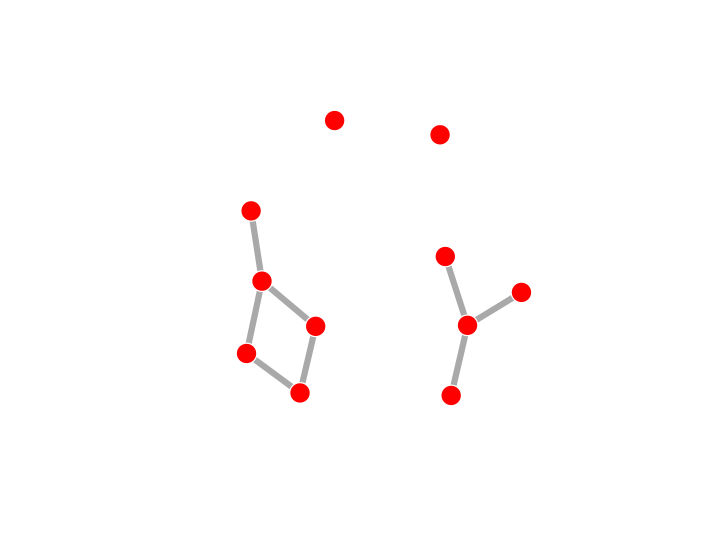

In [11]:
plot(g, vertex.label = "", vertex.color = "red", edge.width = 5)

### Adjacency list
Given a vertex $u$ we can loo at its _adjacents_ or _adjacency set orlist_
$$
A(u) = \{v \in V(G) : (u, v) \in E\}.
$$
Take "a" in our example:

In [14]:
adjacent_vertices(g, "a")

$a
+ 3/11 vertices, named, from 9cef9bb:
[1] b d e


A graph is completely determined by $V$ and the adjacency sets $A(u)$ for each $u \in V$

```r
as_adj_list(graph, mode = c("all", "out", "in", "total"))
```

In [15]:
as_adj_list(g)  

$a
+ 3/11 vertices, named, from 9cef9bb:
[1] b d e

$b
+ 2/11 vertices, named, from 9cef9bb:
[1] a c

$c
+ 2/11 vertices, named, from 9cef9bb:
[1] b d

$d
+ 2/11 vertices, named, from 9cef9bb:
[1] a c

$e
+ 1/11 vertex, named, from 9cef9bb:
[1] a

$h
+ 3/11 vertices, named, from 9cef9bb:
[1] i j k

$i
+ 1/11 vertex, named, from 9cef9bb:
[1] h

$j
+ 1/11 vertex, named, from 9cef9bb:
[1] h

$k
+ 1/11 vertex, named, from 9cef9bb:
[1] h

$f
+ 0/11 vertices, named, from 9cef9bb:

$g
+ 0/11 vertices, named, from 9cef9bb:


## Adjacency Matrix
Take node "a", from its adjacency list we can build the following vector 

In [16]:
as.vector(g["a", ])

[1] 0 1 0 1 1 0 0 0 0 0 0

Then take two nodes "a" and "b":

In [11]:
as.matrix(g[c("a", "b"), ])

,a,b,c,d,e,h,i,j,k,f,g
a,0,1,0,1,1,0,0,0,0,0,0
b,1,0,1,0,0,0,0,0,0,0,0


Putting all vectors together, for each node in $G$, we get a very important matrix, which completely determines $G$: the _adjacency matrix_.

#### Def. Adjacency Matrix

> Given a graph $G = (V, E)$ with $N = |V|$ vertices, which can be labeled from $1, \dots, N$.
The adjacency matrix $A$ of $G$ is defined as
$A = \{a_{ij}\}_{i,j=1}^{N}$, where its elements are
$$a_{ij} = 
\begin{cases}
1 & (i, j) \in V \\
0 & \text{otherwise}
\end{cases}$$

In `igraph`:

```r
as_adjacency_matrix(graph, type = c("both", "upper", "lower"), attr = NULL, 
                    edges = FALSE, names = TRUE, sparse = igraph_opt("sparsematrices"))
```

In [17]:
g[] # equivalently: as_adjacency_matrix(g)

   [[ suppressing 11 column names ‘a’, ‘b’, ‘c’ ... ]]


11 x 11 sparse Matrix of class "dgCMatrix"
                       
a . 1 . 1 1 . . . . . .
b 1 . 1 . . . . . . . .
c . 1 . 1 . . . . . . .
d 1 . 1 . . . . . . . .
e 1 . . . . . . . . . .
h . . . . . . 1 1 1 . .
i . . . . . 1 . . . . .
j . . . . . 1 . . . . .
k . . . . . 1 . . . . .
f . . . . . . . . . . .
g . . . . . . . . . . .

In [18]:
as.matrix(g[])

,a,b,c,d,e,h,i,j,k,f,g
a,0,1,0,1,1,0,0,0,0,0,0
b,1,0,1,0,0,0,0,0,0,0,0
c,0,1,0,1,0,0,0,0,0,0,0
d,1,0,1,0,0,0,0,0,0,0,0
e,1,0,0,0,0,0,0,0,0,0,0
h,0,0,0,0,0,0,1,1,1,0,0
i,0,0,0,0,0,1,0,0,0,0,0
j,0,0,0,0,0,1,0,0,0,0,0
k,0,0,0,0,0,1,0,0,0,0,0
f,0,0,0,0,0,0,0,0,0,0,0


**Observation:** The adjacency matrix of $G$ is a block matrix, $G$ is not connected.

Graphs are also very stuidied as a data structure:

* graphs and trees (an undirected graph $G$ is a tree if for each $u, v \in G$ there exists a unique path connecting $u$ and $v$;
* representations of graphs: adjacency sets and lists, matrices
* search algorithms on graphs
* ...

We will now see several ways to save an igraph-graph and the other way around

```r
write_graph(graph, file, format = c("edgelist", ...), ...)
read_graph(file, format = c("edgelist", ...), ...)
```

In [19]:
as_edgelist(g)
write_graph(g, "g-edge-list.txt", format = "edgelist")
# read_graph("g-edge-list.txt", format = "edgelist")

a,b
b,c
a,d
c,d
a,e
h,i
h,j
h,k


In [14]:
el <- as_edgelist(g)
# write_csv(data.frame(el) , "el.csv", col_names = F)

Small networks can also be saved and build from their adjacency matrix

```r
graph_from_adjacency_matrix(adjmatrix, 
                            mode = c("directed", "undirected", "max", "min", "upper", "lower", "plus"), 
                            weighted = NULL, diag = TRUE, add.colnames = NULL, add.rownames = NA)

from_adjacency(...)
```

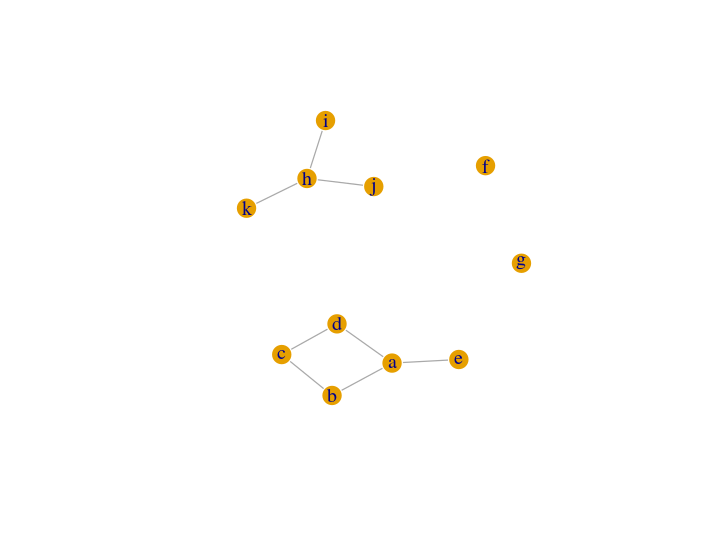

In [20]:
adj_matrix <- as_adjacency_matrix(g)
plot(graph_from_adjacency_matrix(adj_matrix, mode = "undirected"))

In order to write and read the graph using its adjacency matrix, uncomment the code in the next cell. Observe that the sparse matrix is converted to a full matrix `as.matrix(adj_matrix)`, which is usually a problem for larger networks. Alternatively use
```r
writeMM(sparse_matrix,file)
readMM(file)
```
to write/read spare matrices to/from text files; for undirected graphs it is also better to save just a triangular adjacency matrix.

**N.B.** Edge lists are preferred!

In [16]:
# save adjacency matrix, read it and build (plot) the resulting graph
# write.csv(as.matrix(adj_matrix), file = "g-adj-matrix.csv")
# plot(graph_from_adjacency_matrix(as.matrix(read.csv("g-adj-matrix.csv", row.names = 1)), mode = "undirected"))

## Degree of a node

Given a vertex $v \in V$ we can count how many edges are connected to $v$. If the graph is _simple_, i.e. no loops and no multiedges, then the number of $v$'s incident edges is equal to the length of its adjacency list. This is a key number and it is called the _degree_ of vertex $v$.

#### Def. Degree

> The _degree_ $k_i$ of a vertex $i \in G$ is the number of edges incident to $i$. Given $A$ the adjacency matrix of $G$ 
$$k_i = \sum_j a_{ij}.$$

#### Def. Degree distribution.

> Given vertex $i \in G$ we can ask what is the probability of its degree being exactly $k$ and this is given by
$$P(k_i = k) = \frac{n_k}{N}$$
where $n_k$ is the number of nodes having degree $k$.

It is then possible to look at frequency distribution, which is called _degree distribution_.

In [21]:
k_g <- degree(g)
k_g
deg_g <- degree_distribution(g)

a b c d e h i j k f g 
3 2 2 2 1 3 1 1 1 0 0

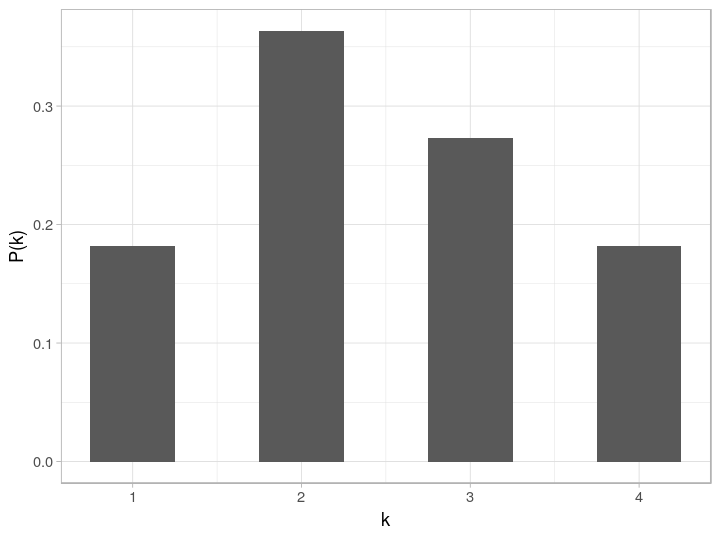

In [22]:
data <- data.frame("k" = 1:length(deg_g), "deg" = deg_g)
ggplot(data, aes(x = k, y = deg)) + 
  geom_col(width = 0.5) +
  labs(x = "k", y = "P(k)") 

## Weighted Graphs

A graph $G = (V, E)$ can also be _weighted_ if we provide a weight function $w: V \times V \to \mathbb{R}$. Let the nodes of $G$ be labeled $1, \dots, N = |V|$ then we write $w_{ij} = w(i, j)$ and $w_{i, j} = 0$ if $(i, j) \notin E$.

In particular 

* if $G$ is undirected the weight function satisfies $w_{ij} = w_{ji}$
* if $G$ is unweighted we can still think of $w$, in which case 
$$w_{ij} = \begin{cases} 1 & (i, j) \in E \\ 0 & (i, j) \notin E. \end{cases} $$

An example of weighted undirected graph is the well-known [Zachary's Karate Club Network](https://www.jstor.org/stable/3629752), often use as a toy model for checking new methods and metrics.  

In [24]:
library(igraphdata)
data(karate)

In [26]:
list.vertex.attributes(karate)

[1] "Faction" "name"    "label"   "color"

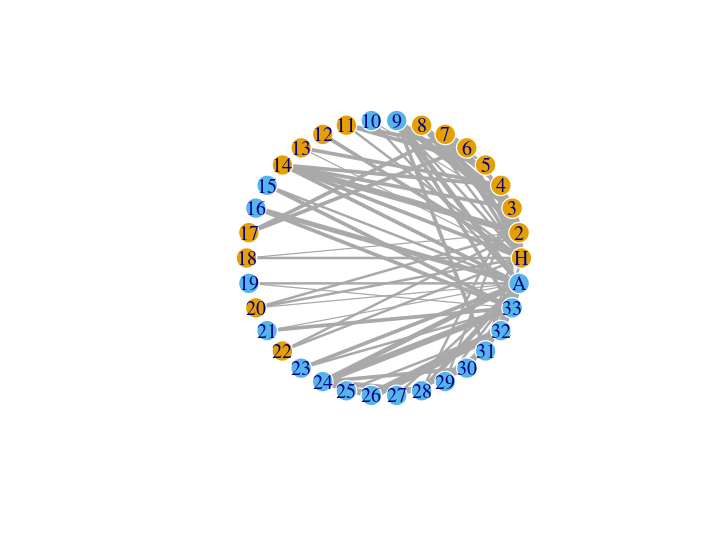

In [27]:
plot(karate, layout = layout_in_circle, edge.width = E(karate)$weight)

By default `karate` nodes are plotted in different colours, reflecting the two factions in this social network. We will see it in detail in the **Community Detection** module.

In [28]:
karate[]

   [[ suppressing 34 column names ‘Mr Hi’, ‘Actor 2’, ‘Actor 3’ ... ]]


34 x 34 sparse Matrix of class "dgCMatrix"
                                                                            
Mr Hi    . 4 5 3 3 3 3 2 2 . 2 3 1 3 . . . 2 . 2 . 2 . . . . . . . . . 2 . .
Actor 2  4 . 6 3 . . . 4 . . . . . 5 . . . 1 . 2 . 2 . . . . . . . . 2 . . .
Actor 3  5 6 . 3 . . . 4 5 1 . . . 3 . . . . . . . . . . . . . 2 2 . . . 2 .
Actor 4  3 3 3 . . . . 3 . . . . 3 3 . . . . . . . . . . . . . . . . . . . .
Actor 5  3 . . . . . 2 . . . 3 . . . . . . . . . . . . . . . . . . . . . . .
Actor 6  3 . . . . . 5 . . . 3 . . . . . 3 . . . . . . . . . . . . . . . . .
Actor 7  3 . . . 2 5 . . . . . . . . . . 3 . . . . . . . . . . . . . . . . .
Actor 8  2 4 4 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Actor 9  2 . 5 . . . . . . . . . . . . . . . . . . . . . . . . . . . 3 . 3 4
Actor 10 . . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 2
Actor 11 2 . . . 3 3 . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Actor 12 3 . . . . . . . . . . . 

**Observations.** 

* Nodes are called "actors" in social network analysis and edges are usually referred to as "ties".
* Entries of the adjacency matrix are now weights $a_{ij} = w_{ij}$.
* The [karate club network](https://www.jstor.org/stable/3629752) is undirected, indeed the adjacency matrix is symmetric:

In [29]:
isSymmetric(as.matrix(karate[]))

[1] TRUE

### Degree of a weighted graph
The _degree_ becomes then a weighted degree $$k_i = \sum_j w_{ij}.$$

We can also build the degree matrix $D$, a diagonal $N \times N$ matrix having $d_{ii} = k_i$ on the diagonal.

In [30]:
head(degree(karate))

Mr Hi Actor 2 Actor 3 Actor 4 Actor 5 Actor 6 
     16       9      10       6       3       4

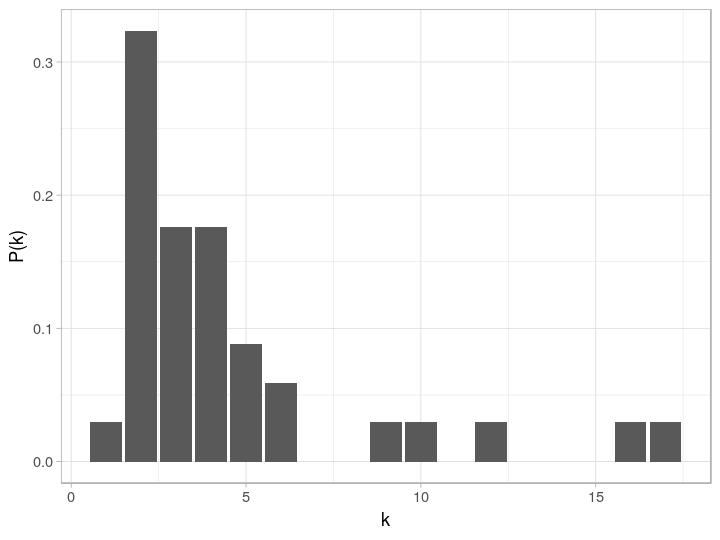

In [31]:
data <- data.frame(deg = degree(karate))
ggplot(data = data, aes(x = deg)) + 
  geom_bar(aes(y = (..count..)/sum(..count..))) +
  labs(x = "k", y = "P(k)")

### 1.2 The Laplacian of a Graph

A very important matrix in network science is the graph's Laplacian matrix $L$, also called admittance or Kirchhoff matrix, together with its _normalised_ counterpart $\textbf{L}$. 
The main reference for the following paragraphs is [Chung, 1997](https://goo.gl/5wh715), a classic book in Spectral graph theory; the first chapther can be found [here](http://www.cs.ucsb.edu/~veronika/MAE/lecturesspectralgraphtheory_chung.pdf).

###### Def. (Graph's Laplacian)

Let $G$ be a weighted undirected graph such that $w$ is not-negative. Then the Laplacian matrix $L$ is a square $N \times N$ matrix defined as
\begin{equation}
    l_{ij} =
    \begin{cases}
    k_i - w_{ii} & \text{if } i = j \\
    - w_{ij} & \text{if } i \neq j \\
    0 & \text{otherwise}
    \end{cases}
\end{equation}
note that $L = D - A$, where $D$ and $A$ are respectively the degree and the adjacency matrices.

In [32]:
Lg <- laplacian_matrix(g, normalized = FALSE)
Lk <- laplacian_matrix(karate, normalized = FALSE, weights = NULL) # if NULL and the graph has an edge attribute called 
                                                                   # weight, then it will be used automatically
Lg
Lk[1:10, 1:5]

   [[ suppressing 11 column names ‘a’, ‘b’, ‘c’ ... ]]


11 x 11 sparse Matrix of class "dgCMatrix"
                                
a  3 -1  . -1 -1  .  .  .  . . .
b -1  2 -1  .  .  .  .  .  . . .
c  . -1  2 -1  .  .  .  .  . . .
d -1  . -1  2  .  .  .  .  . . .
e -1  .  .  .  1  .  .  .  . . .
h  .  .  .  .  .  3 -1 -1 -1 . .
i  .  .  .  .  . -1  1  .  . . .
j  .  .  .  .  . -1  .  1  . . .
k  .  .  .  .  . -1  .  .  1 . .
f  .  .  .  .  .  .  .  .  . 0 .
g  .  .  .  .  .  .  .  .  . . 0

10 x 5 sparse Matrix of class "dgCMatrix"
         Mr Hi Actor 2 Actor 3 Actor 4 Actor 5
Mr Hi       42      -4      -5      -3      -3
Actor 2     -4      29      -6      -3       .
Actor 3     -5      -6      33      -3       .
Actor 4     -3      -3      -3      18       .
Actor 5     -3       .       .       .       8
Actor 6     -3       .       .       .       .
Actor 7     -3       .       .       .      -2
Actor 8     -2      -4      -4      -3       .
Actor 9     -2       .      -5       .       .
Actor 10     .       .      -1       .       .

In [33]:
laplacian_matrix(karate, normalized = FALSE)

   [[ suppressing 34 column names ‘Mr Hi’, ‘Actor 2’, ‘Actor 3’ ... ]]


34 x 34 sparse Matrix of class "dgCMatrix"
                                                                             
Mr Hi    42 -4 -5 -3 -3 -3 -3 -2 -2  . -2 -3 -1 -3  .  .  . -2  . -2  . -2  .
Actor 2  -4 29 -6 -3  .  .  . -4  .  .  .  .  . -5  .  .  . -1  . -2  . -2  .
Actor 3  -5 -6 33 -3  .  .  . -4 -5 -1  .  .  . -3  .  .  .  .  .  .  .  .  .
Actor 4  -3 -3 -3 18  .  .  . -3  .  .  .  . -3 -3  .  .  .  .  .  .  .  .  .
Actor 5  -3  .  .  .  8  . -2  .  .  . -3  .  .  .  .  .  .  .  .  .  .  .  .
Actor 6  -3  .  .  .  . 14 -5  .  .  . -3  .  .  .  .  . -3  .  .  .  .  .  .
Actor 7  -3  .  .  . -2 -5 13  .  .  .  .  .  .  .  .  . -3  .  .  .  .  .  .
Actor 8  -2 -4 -4 -3  .  .  . 13  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
Actor 9  -2  . -5  .  .  .  .  . 17  .  .  .  .  .  .  .  .  .  .  .  .  .  .
Actor 10  .  . -1  .  .  .  .  .  .  3  .  .  .  .  .  .  .  .  .  .  .  .  .
Actor 11 -2  .  .  . -3 -3  .  .  .  .  8  .  .  .  .  .  .  .  .  .  .  .  .
Actor 12 -3  .  .  . 

#### *Laplacian as an Operator

$L$ can be seen as an **operator** on the space of functions $f: V \to \mathbb{R}$.
Indeed let $v^i: V \to \mathbb{R}$ such that $v^i(v_j) = 1$ if $i=j$ and zero otherwise. Then $\{v^1, \dots, v^N\}$ forms a basis of the vector space of all functions from $V$ to $\mathbb{R}$ and every other function $g$ can be written as $g = \sum_i g_i v^i$ and it can be thought as a column vector.

The operator $L$ satisfies
\begin{align}
  Lf(v_i) & = (k_i - w_{ii}) f(v) - \sum_j w_{ij} f(v_j)\\
  & = \sum_{j} w_{ij} \left( f(v_i) - f(v_j) \right) 
\end{align}

and if $G$ is unweighted previous equation can be rewritten as
\begin{equation}
    Lf(v_i) = C \sum_{j} \left( f(v_i) - f(v_j) \right) a_{ij}
\end{equation}
a diffusion operator with diffusion constant $C$.

Indicating with $\langle f, g \rangle = \sum_i f(v_i)g(v_i)$ the standard scalar product in $\mathbb{R}^N$, we also have
\begin{align}
  \langle f, Lf \rangle & = \sum_{i} f(v_i) \sum_{i, j} w_{ij} \left( f(v_i) - f(v_j) \right) \\
  & = \sum_{i, j} w_{ij} \left( f(v_i)^2 - f(v_i)f(v_j) + f(v_j)^2\right) \\
  & = \sum_{i, j} w_{ij} \left( f(v_i) - f(v_j)\right)^2
\end{align}

Looking at the Laplacian as an operator provides to be very useful in characterising its _spectrum_, i.e. the set of its eigenvalues.

#### Normalised Laplacian

Often with "Laplacian" one refers to the normalised matrix $\textbf{L}$.

##### Def. (Normalised Laplacian)
$\textbf{L}$ is defined as
\begin{equation}
    \textbf{l}_{ij} =
    \begin{cases}
    1 - \frac{w_{ii}}{k_i} & \text{if } i = j \\
    - \frac{w_{ih}}{\sqrt{k_i k_j}} & \text{if } i \neq j \text{ and } e_{ij} \in E \\
    0 & \text{otherwise}
    \end{cases}
\end{equation}
and it can be written as $\textbf{L}=D^{-\frac12} L D^{-\frac12}$, with the convention that $D^{-1}(v, v) = 0$ if $k_v=0$, i.e. $v$ is an isolated node.

Further $\textbf{L}=D^{-\frac12} L D^{-\frac12} = D^{-\frac12} (D - A) D^{-\frac12} = I - D^{-\frac12} A D^{-\frac12}$.

Observe that for a _regular_ graph, that is an undirected graph with each vertex having the same degree $k$, last equation reduces to $I - \frac{1}{k} A$.

In [35]:
Lng <- laplacian_matrix(g, normalized = TRUE)
Lnk <- laplacian_matrix(karate, normalized = TRUE)
round(Lng, 3)
round(Lnk[1:10, 1:10], 3)

   [[ suppressing 11 column names ‘a’, ‘b’, ‘c’ ... ]]


11 x 11 sparse Matrix of class "dgCMatrix"
                                                                  
a  1.000 -0.408  .   -0.408 -0.577  .      .      .      .     . .
b -0.408  1.000 -0.5  .      .      .      .      .      .     . .
c  .     -0.500  1.0 -0.500  .      .      .      .      .     . .
d -0.408  .     -0.5  1.000  .      .      .      .      .     . .
e -0.577  .      .    .      1.000  .      .      .      .     . .
h  .      .      .    .      .      1.000 -0.577 -0.577 -0.577 . .
i  .      .      .    .      .     -0.577  1.000  .      .     . .
j  .      .      .    .      .     -0.577  .      1.000  .     . .
k  .      .      .    .      .     -0.577  .      .      1.000 . .
f  .      .      .    .      .      .      .      .      .     0 .
g  .      .      .    .      .      .      .      .      .     . 0

   [[ suppressing 10 column names ‘Mr Hi’, ‘Actor 2’, ‘Actor 3’ ... ]]


10 x 10 sparse Matrix of class "dgCMatrix"
                                                                              
Mr Hi     1.000 -0.115 -0.134 -0.109 -0.164 -0.124 -0.128 -0.086 -0.075  .    
Actor 2  -0.115  1.000 -0.194 -0.131  .      .      .     -0.206  .      .    
Actor 3  -0.134 -0.194  1.000 -0.123  .      .      .     -0.193 -0.211 -0.101
Actor 4  -0.109 -0.131 -0.123  1.000  .      .      .     -0.196  .      .    
Actor 5  -0.164  .      .      .      1.000  .     -0.196  .      .      .    
Actor 6  -0.124  .      .      .      .      1.000 -0.371  .      .      .    
Actor 7  -0.128  .      .      .     -0.196 -0.371  1.000  .      .      .    
Actor 8  -0.086 -0.206 -0.193 -0.196  .      .      .      1.000  .      .    
Actor 9  -0.075  .     -0.211  .      .      .      .      .      1.000  .    
Actor 10  .      .     -0.101  .      .      .      .      .      .      1.000

One can also visualise the Laplacian by means of a heatmap (I use `ggplot`).

**N.B.** You can either load 
* two libraries `ggplot2` and `reshape2`
* just `tidyverse`, [see here](https://www.tidyverse.org/)

I suggest you the second option since `reshape2` is out of maintenance. Unfortunately syntax between `reshape2` and `tidyr` varies a bit, see [tidyr](https://tidyr.tidyverse.org/).

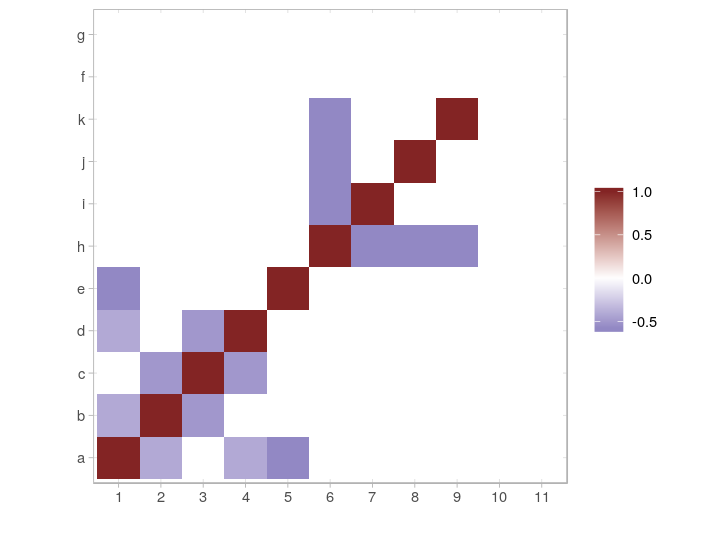

In [36]:
melted_Lng <- as_tibble(as.matrix(Lng)) %>%
  mutate(Var1 = factor(row.names(.), levels = row.names(.))) %>% 
  gather(key = Var2, value = value, -Var1, na.rm = TRUE, factor_key = TRUE) 

# with reshape2 (I used column names Var1 and Var2 for backward compatibility with reshape2::melt())
#
# install.packages("reshape2")  # install the package if you do not have it
# library(reshape2)             # if you want to load the lilbrary, OR just use reshape2:: reshape2 has to be installed
#
# melted_Lng <- reshape2::melt(as.matrix(Lng))

ggplot(data = melted_Lng, aes(x = Var1, y = Var2, fill = value)) + 
  geom_tile() +
  coord_equal() +
  scale_fill_gradient2(low = scales::muted("blue"), mid = "white", high = scales::muted("red")) + 
  labs(x = "", y = "", fill = "")

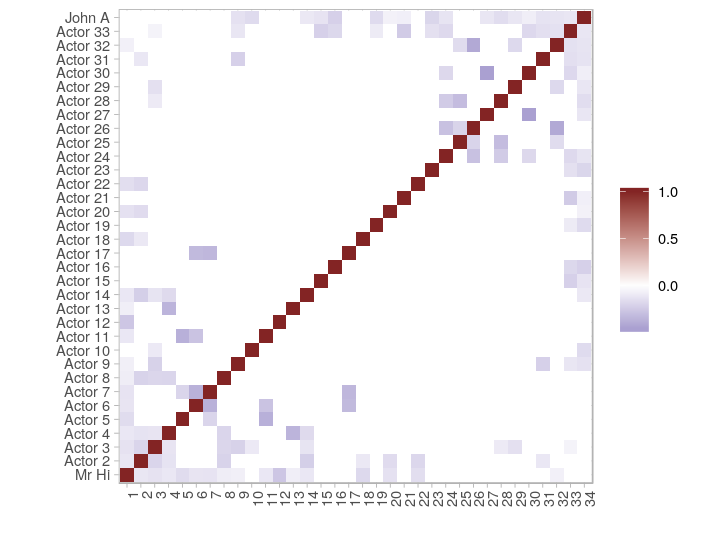

In [28]:
melted_Lnk <- as_tibble(as.matrix(Lnk)) %>%
  mutate(Var1 = factor(row.names(.), levels = row.names(.))) %>% 
  gather(key = Var2, value = value, -Var1, na.rm = TRUE, factor_key = TRUE) 

ggplot(data = melted_Lnk, aes(x = Var1, y = Var2, fill = value)) + 
  geom_tile() +
  coord_equal() +
  scale_fill_gradient2(low = scales::muted("blue"), mid = "white", high = scales::muted("red")) + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "", y = "", fill = "")

#### Eigenvalues of the Laplacian

Due to the assumption of the kernel symmetry $w$, the (normalised) Laplacian is real symmetric, so that its eigenvalues are **all real and non-negative**.

Some important results are briefly summarised, for details and proofs see [Spectral Graph Theory, Chung 1977].
As a function $g:V \to \mathbb{R}$ can be seen as a vector, we may consider the Rayleigh quotient

\begin{align}
    \frac{\langle g, \textbf{L}g \rangle}{\langle g, g \rangle} & = \frac{\langle g, D^{-\frac12} L D^{-\frac12} g \rangle}{\langle g, g \rangle} \\
    & = \frac{\langle f, L f \rangle}{\langle D^{\frac12}f, D^{\frac12} f \rangle} \\
    & = \frac{\sum_{i, j} \left( f(v_i) - f(v_j) \right)^2 w_{ij}}{\sum_{j} \left( f(v_j) \right)^2 k_j} 
\end{align}

From last equation we see that all eigenvalues are non-negative, indeed the smallest eigenvalue of $\textbf{L}$ is $\lambda_0=0$ with eigenvector (or eigenfunction) $\phi_0 = \frac{\textbf{1}D^{\frac12}}{\sqrt{\sum_i k_i}}$, so that $0 = \lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1}$.


<div style="color:gray;padding-top:20pt">
<b>On Rayleigh Quotient.</b>
    
It can be shown that, for a given matrix $M$, the Rayleigh quotient $R(M, x)\frac{x^*Mx}{x^*x}$ reaches its minimum value $\lambda_{\min}$ (the smallest eigenvalue of $M$) when $x = v_{\min }$ (the corresponding eigenvector). 

Similarly, $R(M,x)\leq \lambda _{\max }$ and $R(M,v_{\max })=\lambda _{\max }$.
</div>

In [37]:
eigen(Lnk)

eigen() decomposition
$values
 [1] 1.692239e+00 1.618343e+00 1.589347e+00 1.524742e+00 1.512968e+00
 [6] 1.433716e+00 1.404903e+00 1.373293e+00 1.344767e+00 1.305398e+00
[11] 1.211782e+00 1.133552e+00 1.112145e+00 1.014532e+00 1.000000e+00
[16] 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00
[21] 1.000000e+00 9.558579e-01 8.977235e-01 8.431186e-01 8.082767e-01
[26] 7.795576e-01 7.380337e-01 7.108636e-01 6.454944e-01 5.704647e-01
[31] 4.214591e-01 2.473489e-01 1.100742e-01 6.661338e-16

$vectors
              [,1]         [,2]         [,3]          [,4]          [,5]
 [1,]  0.140879894  0.099229921  0.015237834  6.025471e-03  0.4892835897
 [2,]  0.094610987  0.016903807  0.031745002 -8.704123e-03  0.3853433247
 [3,] -0.038864435 -0.016402572  0.209481357  2.502494e-01 -0.2311411299
 [4,]  0.015332983 -0.003135855  0.021004546  5.131017e-02  0.1086675446
 [5,] -0.041580249 -0.477430288  0.005177156 -2.724742e-05 -0.0099543069
 [6,] -0.040155432 -0.542242971  0.006533821 

### 1.3 Random Walks and Graphs

Random walks and graphs are closely related. Let us build a simple random walk: given a startng point `x_start` and the number of steps `n_step`, the random walker can only move up or down with equal probability.

In [38]:
my_random_walk <- function(x_start, n_steps) {
    r_steps <- rbinom(n = n_steps, size = 1, prob = 0.5)
    r_steps <- 1*(r_steps) - 1*(rep(1, n_steps) - r_steps)
    rw <- cbind(x = c(x_start[1]:(x_start[1] + n_steps)), 
                y = cumsum(c(x_start[2], r_steps)))
    return(rw)
}

In [41]:
rw <- data.frame(my_random_walk(x_start = c(0, 0), n_steps = 2000))

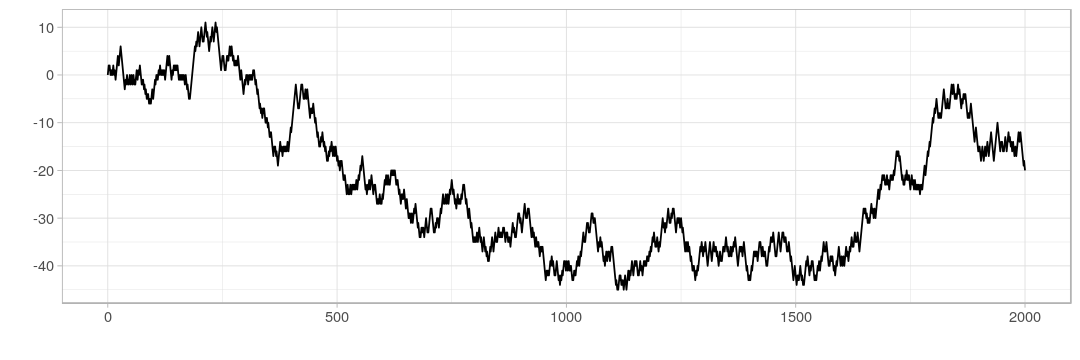

In [42]:
options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(rw, aes(x = x, y = y)) +
  geom_line() +
  labs(x = "", y = "")
options(repr.plot.width = 4*1.5, repr.plot.height = 3*1.5)

Figure: At each step a random walker starting from $x_0 = 0$ can move up or down ($\pm 1$) with equal probability.

We use to represent it graphically by means of a state diagram, which looks like

<img src="./rw-graph-lattice.png" alt="Drawing" style="width: 350px;"/>

This is called a **lattice random walk**, a one dimensional Markov chain with states $\{0, \pm 1, \pm 2, \dots\}$. 
Now let us look at the following graph

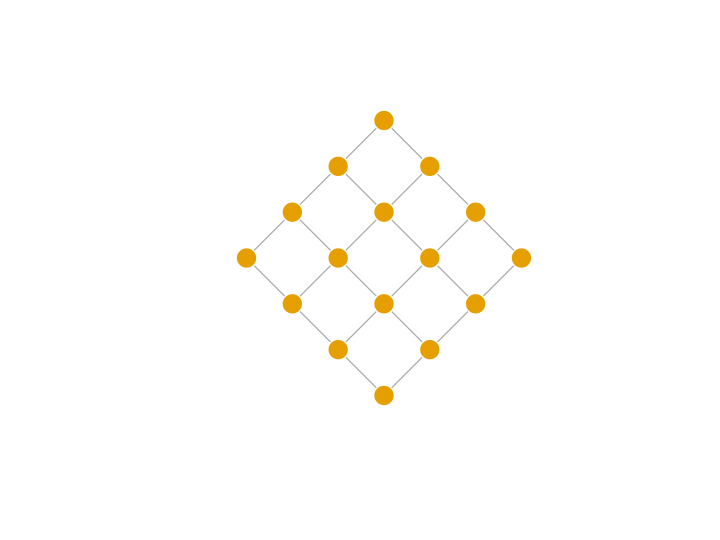

In [32]:
lattice_g <- make_lattice(c(4, 4))
lattice_layout <- as.matrix(expand.grid(x = c(1:4), y = c(1:4))) %*% matrix(c(1/sqrt(2), -1/sqrt(2), 1/sqrt(2), 1/sqrt(2)), nrow = 2)
plot(lattice_g, layout = lattice_layout, vertex.label = "")

This is called a _lattice graph_ or simply a lattice. So we can think of finite state **Markov chains as graphs** where each node has $k_i$ links (in simple undirected graphs), so that the walker can randomly choose one of the $k_i$ possible directions. Let us formalise it.

Let  $G=(V, E)$ be an undirected unweighted graph with vertices $V = 1, \dots, N$, with adjacency matrix $A$ and degree matrix $D = \text{diag}(k_i)$; start a random walk at one node, which may be fixed or drawn from an initial distribution $p_0: V \to \mathbb{R}$ - since $V$ is finite, the initial distribution can be seen as a row vector $\textbf{p}_0=(p_0(i))_{i \in V}$.

Let $X_t$ be the position of the walker at time $t$ and indicate by $p_t(i) = p(X_t = i)$.
If $X_t = i$ in a single time step the walker can move to one of $i$'s adjacent vertices, with probability $\frac{1}{k_i}$.

The sequence of random positions $\{X_t : t = 1, 2, \dots\}$ is a time-homogeneous Markov chain with transition probability
\begin{equation}
  p_{ij} = \frac{a_{ij}}{k_i}.
\end{equation}
In matrix form
\begin{equation*}
  P = D^{-1}A
\end{equation*}
so that the probability of being in $j$ at time $t+1$ is given by
\begin{align}
  p_{t+1}(j) & = \sum_i \frac{a_{ij}}{k_i} p_t(i) \\
  \textbf{p}_{t+1} & = \textbf{p}_t D^{-1}A = \textbf{p}_t P \\
  \textbf{p}_{t+1} & = \textbf{p}_0 P^{t+1}
\end{align}


Probabilities $\textbf{p}_0, \textbf{p}_1, \dots$ are different in general, but for the case of _stationary distribution_ $\boldsymbol{\pi}$, which satisfies
\begin{equation}
  \boldsymbol{\pi} = \boldsymbol{\pi} P.
\end{equation}

In words: if the initial position $X_0$ of the random walker is random with distribution $\boldsymbol{\pi}$ then after $t$ time steps $X_t$ will have the same probability distribution.

If the random walk is (i) **irreducible**, i.e. for all pairs $i, j \in V$ there exists some $s$ such that $p_{ij}^s = p(X_{t+s} = j | X_t = i) > 0$ then a unique stationary distribution exists.

Further, if it is also (ii) **aperiodic**, i.e. $\text{gcd}\{s : p_{ij}^s > 0 \}=1$, then the random walk is said \textit{ergodic} and the following convergence theorem holds

> **Thmeorem [Thm.1.8.3, Norris]**
For any initial distribution $f$
\begin{equation}
  \lim_{s\to\infty} f P^s = \boldsymbol{\pi}
\end{equation}
provided the chain is aperiodic.


The two conditions for ergodicity in terms of graph $G$ are 

* $G$ is connected (i)
* $G$ is non-bipartite (ii).

In terms of eigenvalues of the Laplacian $\textbf{L}$, [Lemma 1.7, Chung 1977]

* $\lambda_1>0$ (i) and 
* $\lambda_{N-1}<2$ (ii).

Now, let us write $P = D^{-1}A = D^{-\frac12}D^{-\frac12}AD^{-\frac12}D^{\frac12} = D^{-\frac12} (I - \textbf{L}) D^{\frac12}$, where $\textbf{L}$ is the **normalised Laplacian**.

It follows that, in a random walk with an associated connected graph, the transition matrix satisfies $\textbf{1} D P=\textbf{1} DD^{-1}A=D$, therefore the stationary distribution
\begin{equation}
\boldsymbol{\pi} = \frac{1}{\sum_i k_i}D.
\end{equation}

**N.B.** Everything can be generalised to weighted connected networks.

A random walk such that $\pi(i)p_{ij}=\pi(j)p_{ji}$ is called _reversible_.
The associated weighted connected network $G$ has weights satisfying
\begin{equation}
w(i, j) = w(j, i) = \pi(i) p_{ij} \frac{1}{c}
\end{equation}
where $c$ is a constant that can be chosen in order to simplify calculations.
Transition probabilities are $p_{ij} = \frac{w(i, j)}{k_i}$ with $k_i$, weighted degree of $i$.

### Further References on Random Walks and Related Articles.

[Masuda, N., Porter, M. A., & Lambiotte, R. (2017). Random walks and diffusion on networks. Physics reports, 716, 1-58.](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.3.041022)

[Noh, J. D., & Rieger, H. (2004). Random walks on complex networks. Physical review letters, 92(11), 118701.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.92.118701).

[De Domenico, M. (2017). Diffusion geometry unravels the emergence of functional clusters in collective phenomena. Physical review letters, 118(16), 168301.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.118.168301).

